# Assignment 4: Movie Review Analysis [50 Pt]

In this assignment, we will build a recurrent neural network to work with sequential text data, specificially, movie review data to identify the reviewer sentiment. In the process of completing this assignment, you will:
    
1. Clean and process text data for machine learning.
2. Perform tokenization of text data.
3. Understand and implement a word-level recurrent neural network.
4. Implement batching of text data using a DataLoader before training a recurrent neural network.
5. Understand how to apply pretrained models for transfer learning in natural language processing projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your Colab file in case your solutions are cut off, **please make sure that your Colab file is publicly accessible at the time of submission.**

In [1]:
# # TO BE COMPLETED

# http://

In [2]:
import sys
print(sys.executable)

/Users/aordorica/miniforge3/envs/pytorch_env/bin/python


In [3]:
!/Users/aordorica/miniforge3/envs/pytorch_env/bin/pip install gcsfs

Looking in indexes: https://artifacts-prod-use1.pinadmin.com/artifactory/api/pypi/pinterest-python-pip-prod-virtual/simple/


In [4]:
!/Users/aordorica/miniforge3/envs/pytorch_env/bin/pip install nltk 

Looking in indexes: https://artifacts-prod-use1.pinadmin.com/artifactory/api/pypi/pinterest-python-pip-prod-virtual/simple/


In [5]:
!/Users/aordorica/miniforge3/envs/pytorch_env/bin/pip install tensorflow

Looking in indexes: https://artifacts-prod-use1.pinadmin.com/artifactory/api/pypi/pinterest-python-pip-prod-virtual/simple/


In [6]:
!/Users/aordorica/miniforge3/envs/pytorch_env/bin/pip install tensorflow_datasets

Looking in indexes: https://artifacts-prod-use1.pinadmin.com/artifactory/api/pypi/pinterest-python-pip-prod-virtual/simple/


# PART A - Sentiment Analysis

In this part we will construct a world-level LSTM model for identifying positive and negative reviews. This will be done in a similar way to what was shared in the preparation code for Assignment 4.

In [7]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aordorica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1. Data Cleaning [5 pt]

We will be using the "IMDB Movie Review Dataset" provided on the course website. Download "IMDB Dataset.csv" into your Colab workspace.

### Part (i) [1pt EXPLORATORY] - comment on data quality - done

Open up the file in Python, and examine some examples of positive and negative reviews. Comment on the quality of the data and any challenges you foresee in working with these data. Pick one example of a positive review and one of a negative review to support your comments.


> There are many html characters such as `\` and brackets such as `<br /><br />`. These are rather used for formatting instead of providing information about the text.
>
>

Context is very important to be able to determine whether a review is positive or negative. Consider the following positive review: 
```
"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side."
```

There are many words that are themselves negative in polarity, such as `violence`, `brutality`, `kill`, etc. However the sentiment is positive because the user became hooked in it. 

Similarly, for a `negative` review we have: 
```

"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."```

There are many words that are themselves positive in polarity, such as `amazing`, `fresh`, `innovative`, etc. However the sentiment is negative because the user explains how it _used_ to be good but it isn't anymore. The user displays disdain and is shocked that the show is still airing.


In [8]:
# download IMDB review data

# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values


In [9]:
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [10]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [11]:
df[df['sentiment']=='positive']['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [12]:
df[df['sentiment']=='negative']['review'].iloc[1]

"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

In [13]:
for i in range(0,5): 
    print(df['review'].iloc[i])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

### Part (ii) [1pt EXPLORATORY] - summary statistics - done

Perform summary statistics on the dataset. What is the average character length of a review? What are the lengths of the longest and shortest reviews?

How many positive reviews and negative reviews are there. Generate a histogram to compare the average character length for positive and negative reviews. Comment on the differences in positive and negative reviews and how that may affect the model you will be using later.

> * The positive reviews tend to have a higher character length than negative reviews. However, their distribution is actually pretty close as we can see in the distribution plots below.
> * There is a low risk that the model ends up considering the length as a feature and bias positive reviews to be longer than negative. However, because this difference is only ~3% from each other, I don't think this will be material. 

sentiment
negative    1294.06436
positive    1324.79768
Name: review_length, dtype: float64


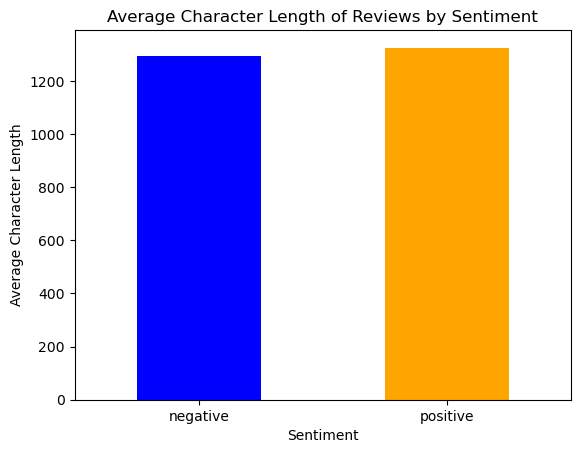

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the length of each review
df['review_length'] = df['review'].str.len()

# Group by sentiment and calculate the average length
avg_lengths = df.groupby('sentiment')['review_length'].mean()

print(avg_lengths)
# Create histogram
avg_lengths.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Character Length of Reviews by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Character Length')
plt.xticks(rotation=0) 
plt.show()


In [15]:
import seaborn as sns




/var/folders/tp/tgqd8prn2x1g474v7zwrxq7r0000gn/T/ipykernel_17886/1878161672.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(review_lengths_positive, label='review length (positive)')
/var/folders/tp/tgqd8prn2x1g474v7zwrxq7r0000gn/T/ipykernel_17886/1878161672.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5

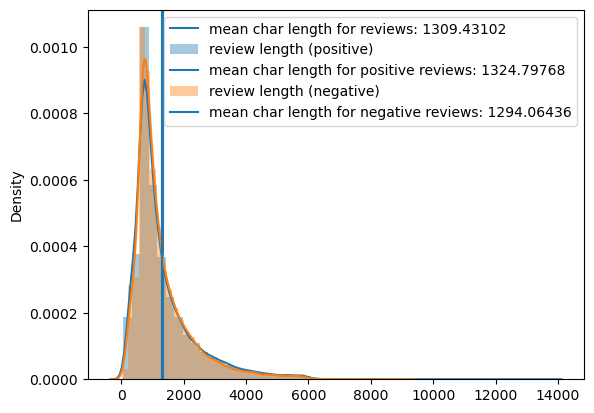

In [16]:
review_lengths = [len(x) for x in list(df['review'])]


plt.axvline(x = np.mean(review_lengths), label=f'mean char length for reviews: {np.mean(review_lengths)}')

review_lengths_positive = [len(x) for x in list(df[df['sentiment']=='positive']['review'])]
sns.distplot(review_lengths_positive, label='review length (positive)')
plt.axvline(x = np.mean(review_lengths_positive), label=f'mean char length for positive reviews: {np.mean(review_lengths_positive)}')

review_lengths_negative = [len(x) for x in list(df[df['sentiment']=='negative']['review'])]
sns.distplot(review_lengths_negative, label='review length (negative)')
plt.axvline(x = np.mean(review_lengths_negative), label=f'mean char length for negative reviews: {np.mean(review_lengths_negative)}')
plt.legend()
plt.show()







### Part (iii) [1pt EXPLORATORY] - description of the functions - done 

The following helper code will be used to process the data before we can train our LSTM model. In point form comment on what processing steps are performed in the code provided below and why these steps are necessary or beneficial to training and LSTM.

In [17]:
X[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [18]:
import tensorflow_datasets as tfds

/Users/aordorica/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import tensorflow
raw_train_set, raw_valid_Set, raw_test_set = tfds.load(
    name= 'imdb_reviews', 
    split=['train[:90%]', 'train[90%:]', 'test'], as_supervised=True
    
)



In [20]:
for review, label in raw_train_set.take(4): 
    print(review.numpy().decode('utf-8'))
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development

2023-11-18 13:00:14.622000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
[x for x in list(df['review']) if 'This was an absolutely terrible movie' in x]

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."]

In [22]:
df.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [23]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

#### `preprocess_string(str1)`
> `preprocess_string(str1)` removes all non-word characters excluding number and letters. This can get rid of the html brackets like the ones in `<br /><br />`.

#### `preprocess_sentence(sen1)`

> `preprocess_sentence(sen1)` uses `stop_word = set(stopwords.words("english"))` to create a set of English stop words using the stopwords resource from a library like NLTK. Stop words are common words (like "the", "is", "in") that are often removed in natural language processing because they're usually not informative for tasks like sentiment analysis. This function then converts the sentence to lowercase to ensure consistency in capitalization, so that capitalization does not alter the sentiment in the sentence.
> * The sentence is then split into individual words and uses the `preprocess_string` function defined above to remove non-word characters, white spaces, and digits. The function returns `word_list`, which contains the preprocessed words from the original sentence that are neither stop words nor empty strings.

#### `get_stoi(data)` 
> Processes the entire dataset to create a condensed vocabulary of the most frequent words and then generates a mapping from these words to unique integer indices. This mapping is crucial for converting textual data into a numerical format that can be used by machine learning models. This step reduces the vocabulary to the most common words, which is often beneficial in reducing the complexity of the model and focusing on the most relevant words. For example: 
> ```
{'oz': 1,
 'right': 2,
 'br': 3,
 'violence': 4,
 'show': 5,
 'one': 6,
 'reviewers': 7,
 'mentioned': 8,
 'watching': 9,
 'episode': 10,
 'youll': 11,
 'hooked': 12,
 'exactly': 13,
 'happened': 14,
...
 'classic': 35,
 'use': 36,
 'wordbr': 37}
    ```


#### `tokenize(data, labels, stoi)`
> This function function performs two key tasks: it tokenizes and encodes the text data (data) and also encodes the sentiment labels. The purpose of this function is to convert the raw text data into a numerical format that can be processed by machine learning models, specifically models like LSTMs that require numerical input. The encoding of labels into a binary format is also essential for the model to perform classification tasks, such as sentiment analysis.

#### `padding_(sentences, seq_len)`
> * The `padding_` function performs padding of the tokenized and encoded sentence sequences to ensure they all have the same length. This is a crucial step when preparing data for training neural network models, especially models like LSTMs that require input sequences of uniform length. `seq_len` establishes the baseline length of these sequences and the function replaces the empty spots with zeros. For each sentence (`review`), it checks if the sentence is non-empty.
> * If the sentence is non-empty, it pads the sentence to ensure that it has a consistent length of `seq_len`.
> * If the sentence is longer than `seq_len`, it is truncated to fit the specified length.
> *  The line `features[ii, -len(review):] = np.array(review)[:seq_len]`  If the length of the review is less than seq_len, the beginning of this row will remain zeros, effectively adding zeros (padding) at the beginning of the sequence.

In [24]:
str1="""One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. 
They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />I
"""
preprocess_sentence(str1)

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'youll',
 'hooked',
 'right',
 'exactly',
 'happened',
 'mebr',
 'br',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'wordbr',
 'br']

In [25]:
get_stoi(str1)

<built-in method get of Counter object at 0x2b21408b0>


{'e': 1,
 'h': 2,
 'r': 3,
 'n': 4,
 'c': 5,
 'w': 6,
 'u': 7,
 'l': 8,
 'f': 9,
 'g': 10,
 'b': 11,
 'p': 12,
 'v': 13,
 'z': 14,
 'k': 15,
 'x': 16,
 'j': 17}

In [26]:
get_stoi(preprocess_sentence(str1))

<built-in method get of Counter object at 0x2b2140630>


{'oz': 1,
 'right': 2,
 'br': 3,
 'violence': 4,
 'show': 5,
 'one': 6,
 'reviewers': 7,
 'mentioned': 8,
 'watching': 9,
 'episode': 10,
 'youll': 11,
 'hooked': 12,
 'exactly': 13,
 'happened': 14,
 'mebr': 15,
 'first': 16,
 'thing': 17,
 'struck': 18,
 'brutality': 19,
 'unflinching': 20,
 'scenes': 21,
 'set': 22,
 'word': 23,
 'go': 24,
 'trust': 25,
 'faint': 26,
 'hearted': 27,
 'timid': 28,
 'pulls': 29,
 'punches': 30,
 'regards': 31,
 'drugs': 32,
 'sex': 33,
 'hardcore': 34,
 'classic': 35,
 'use': 36,
 'wordbr': 37}

In [27]:

re.sub(r"[^\w\s]",'',str1)

'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked \nThey are right as this is exactly what happened with mebr br The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordbr br I\n'

In [28]:
re.sub(r"[^\w\s]", '', str1)


'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked \nThey are right as this is exactly what happened with mebr br The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordbr br I\n'

In [29]:
re.sub(r"\s",'',"<br /><br />")

'<br/><br/>'

### Part (iv) [1pt EXPLORATORY] - train/test split and data pre processing

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split. Then apply the above processing steps to prepare your data for training.

Set the padding of the reviews to 500.

In [30]:
import pandas as pd
import numpy as np
# Assigning a random number between 0 and 1 to each row in the DataFrame
df['random_number'] = np.random.rand(df.shape[0])
df.head()

,review,sentiment,review_length,random_number
0,One of the other reviewers has mentioned that ...,positive,1761,0.726664
1,A wonderful little production. <br /><br />The...,positive,998,0.574499
2,I thought this was a wonderful way to spend ti...,positive,926,0.503340
3,Basically there's a family where a little boy ...,negative,748,0.772244
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,0.774763


/var/folders/tp/tgqd8prn2x1g474v7zwrxq7r0000gn/T/ipykernel_17886/3062769337.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['random_number'])


<Axes: xlabel='random_number', ylabel='Density'>

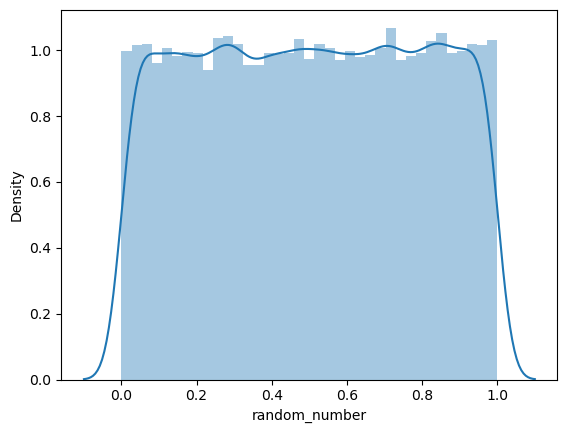

In [31]:
sns.distplot(df['random_number'])

#### Splitting the dataset based on the random number for a 60-20-20 split

In [32]:
# Splitting the dataset based on the random number for a 60-20-20 split
train_df = df[df['random_number'] <= 0.6]
val_df = df[(df['random_number'] > 0.6) & (df['random_number'] <= 0.8)]
test_df = df[df['random_number'] > 0.8]

# You can now drop the 'random_number' column if it's no longer needed
train_df = train_df.drop('random_number', axis=1)
val_df = val_df.drop('random_number', axis=1)
test_df = test_df.drop('random_number', axis=1)

# The datasets are now split into train (60%), validation (20%), and test (20%) sets
train_df, val_df, test_df

(                                                  review sentiment  \
 1      A wonderful little production. <br /><br />The...  positive   
 2      I thought this was a wonderful way to spend ti...  positive   
 6      I sure would like to see a resurrection of a u...  positive   
 8      Encouraged by the positive comments about this...  negative   
 9      If you like original gut wrenching laughter yo...  positive   
 ...                                                  ...       ...   
 49992  John Garfield plays a Marine who is blinded by...  positive   
 49994  This is your typical junk comedy.<br /><br />T...  negative   
 49995  I thought this movie did a down right good job...  positive   
 49998  I'm going to have to disagree with the previou...  negative   
 49999  No one expects the Star Trek movies to be high...  negative   
 
        review_length  
 1                998  
 2                926  
 6                726  
 8                681  
 9                176  
 .

### Steps to prepare data for training: 
1. **Preprocess the Reviews:** Apply `preprocess_sentence` to each review in the dataframe. This will tokenize the reviews, remove stopwords, and clean them.
2. **Create a Vocabulary to Index Mapping (stoi):** Use the `get_stoi` function to create a dictionary that maps each unique word in your corpus to a unique integer. This is essential for encoding the words in your reviews into numerical format.
3. **Tokenize and Encode the Labels:** Use the tokenize function to convert each review into a list of integers based on your stoi mapping. Also, encode the labels `('positive' and 'negative')` into binary format (1 and 0).
4. **Pad the Sequences:** Use the `padding_ function` to pad the tokenized reviews to a fixed length of 500. This is necessary to ensure that all input sequences to your model are of the same length.

#### 1.Apply preprocess_sentence to the 'review' column

In [33]:
df['processed_review'] = df['review'].apply(preprocess_sentence)
train_df['processed_review'] = train_df['review'].apply(preprocess_sentence)
val_df['processed_review'] = val_df['review'].apply(preprocess_sentence)
test_df['processed_review'] = test_df['review'].apply(preprocess_sentence)

df.head()

,review,sentiment,review_length,random_number,processed_review
0,One of the other reviewers has mentioned that ...,positive,1761,0.726664,"[one, reviewers, mentioned, watching, oz, epis..."
1,A wonderful little production. <br /><br />The...,positive,998,0.574499,"[wonderful, little, production, br, br, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,926,0.503340,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,748,0.772244,"[basically, theres, family, little, boy, jake,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,0.774763,"[petter, matteis, love, time, money, visually,..."


#### 2. Create `stoi` mapping based on training data only

In [34]:
# Aggregate all words from all reviews
all_words = []

for review in train_df['review']:
    processed_review = preprocess_sentence(review)
    all_words.extend(processed_review)

In [35]:

# Count the occurrences of each word
word_count = Counter(all_words)
# Create the stoi mapping
stoi = {word: i + 1 for i, word in enumerate(word_count)}

#### 3. Tokenize and Encode the Labels

In [36]:
train_tokenized_data, train_encoded_labels = tokenize(train_df['review'], train_df['sentiment'], stoi)
val_tokenized_data, val_encoded_labels = tokenize(val_df['review'], val_df['sentiment'], stoi)
test_tokenized_data, test_encoded_labels = tokenize(test_df['review'], test_df['sentiment'], stoi)


/var/folders/tp/tgqd8prn2x1g474v7zwrxq7r0000gn/T/ipykernel_17886/626589820.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


##### 3.1 Visualizing example of how tokenization is working 

In [37]:
def find_keys_for_value(dictionary, target_value):
    keys = [key for key, value in dictionary.items() if value == target_value]
    return keys

In [38]:
train_df.head()

,review,sentiment,review_length,processed_review
1,A wonderful little production. <br /><br />The...,positive,998,"[wonderful, little, production, br, br, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,926,"[thought, wonderful, way, spend, time, hot, su..."
6,I sure would like to see a resurrection of a u...,positive,726,"[sure, would, like, see, resurrection, dated, ..."
8,Encouraged by the positive comments about this...,negative,681,"[encouraged, positive, comments, film, looking..."
9,If you like original gut wrenching laughter yo...,positive,176,"[like, original, gut, wrenching, laughter, lik..."


In [39]:
train_df.head()['review'].iloc[0][0:100]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B'

In [40]:
print(train_tokenized_data[0][0:10])

[1, 2, 3, 4, 4, 5, 6, 7, 8, 9]


In [41]:
for token in train_tokenized_data[0][0:10]: 
    keys_with_target_value = find_keys_for_value(stoi, token)
    print(keys_with_target_value[0])

wonderful
little
production
br
br
filming
technique
unassuming
oldtimebbc
fashion


#### 4. Pad the Sequences

In [42]:
# Set your desired sequence length
sequence_length = 500

# Pad the tokenized reviews

tokenized_data, encoded_labels = tokenize(df['review'], df['sentiment'], stoi)

train_tokenized_data, train_encoded_labels = tokenize(train_df['review'], train_df['sentiment'], stoi)
val_tokenized_data, val_encoded_labels = tokenize(val_df['review'], val_df['sentiment'], stoi)
test_tokenized_data, test_encoded_labels = tokenize(test_df['review'], test_df['sentiment'], stoi)



train_padded_reviews = padding_(train_tokenized_data, sequence_length)
val_padded_reviews = padding_(val_tokenized_data, sequence_length)
test_padded_reviews = padding_(test_tokenized_data, sequence_length)

train_padded_reviews

/var/folders/tp/tgqd8prn2x1g474v7zwrxq7r0000gn/T/ipykernel_17886/626589820.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


array([[    0,     0,     0, ...,    77,    20,    78],
       [    0,     0,     0, ...,   152,    29,   153],
       [    0,     0,     0, ...,   208,   152,   209],
       ...,
       [    0,     0,     0, ...,  4190,  2099,     4],
       [    0,     0,     0, ..., 44050, 12481,   163],
       [    0,     0,     0, ...,  6265,  2869,   263]])

In [43]:
train_df.head()

,review,sentiment,review_length,processed_review
1,A wonderful little production. <br /><br />The...,positive,998,"[wonderful, little, production, br, br, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,926,"[thought, wonderful, way, spend, time, hot, su..."
6,I sure would like to see a resurrection of a u...,positive,726,"[sure, would, like, see, resurrection, dated, ..."
8,Encouraged by the positive comments about this...,negative,681,"[encouraged, positive, comments, film, looking..."
9,If you like original gut wrenching laughter yo...,positive,176,"[like, original, gut, wrenching, laughter, lik..."


In [44]:
train_df.head()['review'].iloc[0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [45]:
for x in train_df.head()['processed_review'].iloc[0]:
    print(x)

wonderful
little
production
br
br
filming
technique
unassuming
oldtimebbc
fashion
gives
comforting
sometimes
discomforting
sense
realism
entire
piece
br
br
actors
extremely
well
chosen
michael
sheen
got
polari
voices
pat
truly
see
seamless
editing
guided
references
williams
diary
entries
well
worth
watching
terrificly
written
performed
piece
masterful
production
one
great
masters
comedy
life
br
br
realism
really
comes
home
little
things
fantasy
guard
rather
use
traditional
dream
techniques
remains
solid
disappears
plays
knowledge
senses
particularly
scenes
concerning
orton
halliwell
sets
particularly
flat
halliwells
murals
decorating
every
surface
terribly
well
done


In [46]:
len(train_df.head()['processed_review'].iloc[0]) == len([x for x in train_padded_reviews[0] if x >0])

True

In [47]:
train_padded_reviews[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [48]:
##### Verifying shapes are matching 

In [49]:
df.shape

(50000, 5)

In [51]:
train_tokenized_data.shape, train_padded_reviews.shape, train_encoded_labels.shape

((29839,), (29839, 500), (29839,))

In [52]:
train_tokenized_data.shape[0]/tokenized_data.shape[0]

NameError: name 'tokenized_data' is not defined

### Part (v) [1pt EXPLORATORY] - Create DataLoader

Create a DataLoader that will allow you to load the training and validation data in mini-batches. Then generate a dataset of batch size of 16 to verify that the DataLoader works as intended.

In [66]:
from torch.utils.data import Dataset, DataLoader
import torch

class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        sample = {"review": torch.tensor(review, dtype=torch.long),
                  "label": torch.tensor(label, dtype=torch.long)}
        return sample

# Assuming train_padded_reviews and train_encoded_labels are your training data and labels
# And valid_padded_reviews and valid_encoded_labels are your validation data and labels

train_dataset = ReviewDataset(train_padded_reviews, train_encoded_labels)
val_dataset = ReviewDataset(val_padded_reviews, val_encoded_labels)



In [55]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [56]:
# Iterate over training DataLoader
for i, data in enumerate(train_loader):
    reviews, labels = data['review'], data['label']
    print(f"Batch {i+1}")
    print(f"Review batch shape: {reviews.shape}")
    print(f"Label batch shape: {labels.shape}")
    # Add a break to stop after the first batch for demonstration purposes
    break


Batch 1
Review batch shape: torch.Size([16, 500])
Label batch shape: torch.Size([16])


In [64]:
# Get one batch from the train_loader
for batch in train_loader:
    sample_reviews, sample_labels = batch['review'], batch['label']
    break  # We break the loop to only get the first batch

# Now sample_reviews and sample_labels contain one batch of your data

# You can print the shape of the samples to verify
print("Shape of Reviews:", sample_reviews.shape)
print("Shape of Labels:", sample_labels.shape)

# Print the actual data (optional, could be large depending on your sequence length)
sample_reviews

Shape of Reviews: torch.Size([16, 500])
Shape of Labels: torch.Size([16])


tensor([[    0,     0,     0,  ...,   175,   699,    80],
        [    0,     0,     0,  ...,   138,  3722,  1862],
        [    0,     0,     0,  ...,   810,  7179,   772],
        ...,
        [    0,     0,     0,  ...,  4708, 88825,  1610],
        [    0,     0,     0,  ...,  8826,   805, 33750],
        [    0,     0,     0,  ...,   218,   321,    82]])

In [65]:
sample_labels

tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0])

## Part 2. Model Building [2pt MODEL]

Build a recurrent neural network model, using an architecture of your choosing. Use one or more fully-connected layers to make the prediction based on your recurrent network output.

Instead of using the RNN output value for the final token, another often used strategy is to max-pool over the entire output array. That is, instead of calling something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# TO BE COMPLETED

class SentimentRNN(nn.Module):
    def __init__(self):
        super(SentimentRNN, self).__init__()

        # TO BE COMPLETED

    def forward(self, x, hidden):

        # TO BE COMPLETED






model = SentimentRNN()


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """

    # TO BE COMPLETED



### Part (ii) [1pt MODEL]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [ ]:
# TO BE COMPLETED







### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part 4. Evaluation [10 pt]

**Important**. At this point in the assignment your test data should not have been evaluated by any of your models. The test data should be evaluated only after you have finished all the previous parts of the assignment. Once you evaluate your models on the test data you cannot change your models or else you may make hyperparameter adjustments that could lead to overfitting to the test data.

### Part (i) [3pt RESULT]

Report the final test accuracy of your model. Comment on how the result compares with accuracy obtained on the training and validation data. Are the results what you expected? Explain.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''


### Part (ii) [3pt DISCUSSION]

Look over the misclassified samples in the test data and see if you can find any patterns on where the model has difficulty with identifying the review sentiment. Provide up to 5 examples of positive and negative reviews each to support your findings.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''


### Part (iii) [2pt RESULT]

What is your model's prediction of the **probability** that
the review message provided below is a positive review?

Hint: You will need to apply the same processing on the review as was done on the the train, val, and test data sets.

In [ ]:
review = """ Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one. "



In [ ]:
# TO BE COMPLETED







### Part (iv) [2pt DISCUSSION]

Do you think that detecting positive and negative reviews is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

# PART B - Transfer Learning

For many natural language processing tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to enormous compute requirements and lack of sufficient amounts of training data. Instead, you should always try to take advantage of an existing model that performs similar tasks as the one you need to solve.

In this part of the assignment we will be using pretrained models to improve the performance on identifying positive and negative reviews. There are several pretrained models that are available to us, here we will use a pretrained BERT model that comes with the hugging face transformer library.

Provided below is sample code to get you started. For more details please visit the hugging face tutorial on using pretrained models using PyTorch: https://huggingface.co/docs/transformers/training

#### Sample Code

In [ ]:
# install relevant libraries
!pip install -qq transformers

In [ ]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

In [ ]:
encoding['input_ids']

In [ ]:
encoding['attention_mask']

In [ ]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [ ]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading [5 pt]

We will be using the same "IMDB Movie Review Dataset" that we used earlier. Reload the data and complete Part B of the assignment. You should be able to complete part B independently from Part A.

### Part (i) [1pt EXPLORATORY]

Provided below is a DataLoader for your training and test datasets so you can iterate over batches of data. Run the DataLoader to create your training, validation, and test data.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 16

#training data
train_data = MovieReviewDataset(reviews=df_train['review'].to_numpy(),
                                targets=df_train['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE, num_workers = 4) #modify num_works as needed

#validation data

# TO BE COMPLETED

#test data

# TO BE COMPLETED




### Part (ii) [1pt EXPLORATORY]

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iii) [1pt EXPLORATORY]

Determine the range of values for the tokens in the training data. How are the tokens obtained?

Hint: You can apply your intuition here, or do some additional research to find how the "bert-base-cased" tokenization is done.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iv) [1pt EXPLORATORY]

Generate histograms of all the token values in the training data. Repeat for the validation and test data. What are the top 5 occuring tokens in the training_dataset? What do these tokens represent?

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (v) [1pt EXPLORATORY]

Select a single sample from your training DataLoader and feed it through the **bert_model** to obtain the hidden_states and pooled_output. Briefly describe what each tensor dimension represents and what affects the size of each dimension.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part 2. Model Architecture [2 pt]

### Part (i) [1pt MODEL]

Prepare a review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifierPooled, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    # TO BE COMPLETED

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]

    # TO BE COMPLETED



### Part (ii) [1pt MODEL]

Construct the architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierLast(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifierLast, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    # TO BE COMPLETED

  def forward(self, input_ids, attention_mask):

    # TO BE COMPLETED


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """

    # TO BE COMPLETED



### Part (ii) [1pt MODEL]

Write a function **train_model** to train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [ ]:
# TO BE COMPLETED




### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters. You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part 4. Evaluation [10 pt]

### Part (i) [3pt RESULT]

Report the final test accuracy of your best BERT-based model. Then summarize in a pandas dataframe the accuracy obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.



In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (ii) [2pt RESULT]

Report the false positive rate and false negative rate of your model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of your model obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.

In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iii) [3pt DISCUSSION]
Examine some of the misclassified reviews from you best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.

Is there any part of the review that you could modify to make the classifications correct? Try to make small changes to the review to see if you can make the model make the correct classification while keeping the review as close to the original as possible.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iv) [2pt DISCUSSION]
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with your best BERT and LSTM models from parts A and B. How well do they perform?

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to take on a challenging task.

In part A we constructed and trained an LSTM model to identify the sentiment in movie reviews. In Part B we used the embeddings of a BERT model pretrained on a large corpus of text to demonstrate how transfer learning can be used to improve our movie sentiment model. The BERT model is one of many language models that we could have used to implement transfer learning.

For this bonus challenge you are asked to implement a generative character-level LSTM model to produce IMDB movie reviews. Once the model is sufficiently trained you can then use its hidden states as the embedding for training a movie sentiment model. Construct your new movie sentiment analysis model and compare the performance against the model from part A and B.

There are many variants of a generative LSTM model that you can consider. As a starting point you can use the generative LSTM sample code provided in the lecture notes. Specifically, the one used to generate Shakeaspeare. More advanced versions of a generative LSTM can be found in the Universal Language Model Fine-turing for Text Classification (ULMfit) paper (https://arxiv.org/abs/1801.06146).

Tasks:

1. Create a generative character-level LSTM model trained to create IMDB reviews
2. Create a classifier using the embeddings from the generative LSTM model (from step 1) to identify positive and negative reviews.
3. Compare the performance of the model with the results in parts A and B of the assignment.
4. Upgrade the generative LSTM model using the techniques listed in the ULMfit paper (e.g., bi-directional LSTM, pretraining with wikipedia text and fine-tuning on IMDBT reviews, etc.).

Bonus marks will be provided based on the number of steps completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.


In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
#!pip install nbconvert

%%shell
jupyter nbconvert --to html /content/A4.ipynb


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **10 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**